# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import talib as ta #TA-Lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [2]:
#lendo o arquivo csv
df = pd.read_csv("USDCHF_Candlestick_1_D_BID_30.08.2018-30.12.2020.csv")


In [3]:
#arrumando a coluna gmt time para ficar só com o time e retirar a hora
from datetime import datetime
for i in range(len(df)):
    df['Gmt time'][i] = datetime.strptime(df['Gmt time'][i], '%d.%m.%Y %H:%M:%S.%f').strftime('%Y-%m-%d')

   

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
df.set_index('Gmt time', inplace = True)

In [5]:
df = df.drop_duplicates()

# calculando features e organizando os dados no dataframe

In [6]:
df['body'] = (df['Close']-df['Open'])*10000
df['pavio_sup'] = (df['High']-df['Open'])*10000
df['pavio_inf'] = (df['Close']-df['Low'])*10000


In [7]:
df.loc[df['body']>0, 'pavio_sup']=(df['High'][df['body']>0]-df['Close'][df['body']>0])*10000
df.loc[df['body']>0, 'pavio_inf']=(df['Open'][df['body']>0]-df['Low'][df['body']>0])*10000

In [8]:
df['SMA_50'] = ta.SMA(np.array(df['Close']),timeperiod=50)
df['SMA_20'] = ta.SMA(np.array(df['Close']), timeperiod=20)
df['ATR'] = ta.ATR(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=50)
df['CCI'] = ta.CCI(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=20)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']))

In [9]:
for i in np.arange(1,97):
    df['return_'+str(i)]=df['Close'].pct_change(i)
    df['lag_return_'+str(i)]=df['return_1'].shift(i)

In [10]:
df.loc[:,'sobe_desce']=-1 
df.loc[df['return_1'].shift(-1)>0,'sobe_desce']=1 
df = df.drop(columns=['return_1']) 

In [11]:
df = df.dropna(axis=0, how='any')

In [12]:
df

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-21,0.99510,0.99510,0.99510,0.99510,0.0000,0.0,0.0,0.0,0.998295,0.994377,...,-0.006761,0.024103,-0.002556,0.021485,0.005263,0.026861,0.000609,0.027486,0.000000,-1
2018-12-23,0.99344,0.99513,0.98561,0.98623,112752.7298,-72.1,16.9,6.2,0.998081,0.993757,...,0.003647,0.021884,-0.006761,0.014974,-0.002556,0.012380,0.005263,0.017708,0.000609,-1
2018-12-24,0.98623,0.98722,0.98358,0.98439,1847.4600,-18.4,9.9,8.1,0.997831,0.993045,...,0.000000,0.016270,0.003647,0.019977,-0.006761,0.013080,-0.002556,0.010491,0.005263,1
2018-12-25,0.98692,0.99631,0.98514,0.99557,69106.6400,86.5,7.4,17.8,0.997707,0.992951,...,0.006504,0.027812,0.000000,0.027812,0.003647,0.031561,-0.006761,0.024586,-0.002556,-1
2018-12-26,0.99547,0.99566,0.98398,0.98772,147032.3209,-77.5,1.9,37.4,0.997358,0.992478,...,-0.002872,0.013119,0.006504,0.019708,0.000000,0.019708,0.003647,0.023427,-0.006761,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.88908,0.89185,0.88758,0.88889,56853.4799,-1.9,27.7,13.1,0.899911,0.887545,...,-0.002021,-0.023734,-0.002017,-0.025703,-0.005797,-0.031351,0.001878,-0.029533,0.002989,-1
2020-12-28,0.88889,0.88939,0.88302,0.88389,59526.0995,-50.0,5.0,8.7,0.899252,0.887156,...,0.000000,-0.027260,-0.002021,-0.029226,-0.002017,-0.031184,-0.005797,-0.036800,0.001878,-1
2020-12-29,0.88374,0.88544,0.88109,0.88118,67425.5202,-25.6,17.0,0.9,0.898507,0.886702,...,-0.000506,-0.030242,0.000000,-0.030242,-0.002021,-0.032202,-0.002017,-0.034154,-0.005797,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 2018-12-21 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1020.3+ KB


In [14]:
df =df.iloc[8:]

In [15]:
df.head(100)

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.98099,0.98099,0.98099,0.98099,0.0000,0.0,0.0,0.0,0.995617,0.990398,...,0.000000,0.014247,0.001927,0.016201,-0.005440,0.010673,-0.001543,0.009114,-0.002872,1
2019-01-01,0.98120,0.99200,0.97960,0.99000,123098.3795,88.0,20.0,16.0,0.995329,0.990384,...,-0.004839,0.023563,0.000000,0.023563,0.001927,0.025535,-0.005440,0.019956,-0.001543,-1
2019-01-02,0.99000,0.99087,0.98459,0.98669,165175.6400,-33.1,8.7,21.0,0.995015,0.990060,...,0.002036,0.025101,-0.004839,0.020140,0.000000,0.020140,0.001927,0.022106,-0.005440,-1
2019-01-03,0.98660,0.99078,0.98528,0.98616,142161.0608,-4.4,41.8,8.8,0.994700,0.989695,...,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,0.019592,0.001927,-1
2019-01-04,0.98616,0.98616,0.98616,0.98616,0.0000,0.0,0.0,0.0,0.994306,0.989305,...,-0.008531,0.019751,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-21,1.01313,1.01606,1.01312,1.01507,30123.0299,19.4,9.9,0.1,1.001669,1.003958,...,-0.000537,0.028763,-0.003343,0.025323,0.009185,0.034740,0.000000,0.034740,-0.002947,1
2019-04-22,1.01448,1.02301,1.01448,1.01992,73976.8211,54.4,30.9,0.0,1.002062,1.005203,...,0.000000,0.034234,-0.000537,0.033678,-0.003343,0.030222,0.009185,0.039684,0.000000,1
2019-04-23,1.01992,1.02194,1.01686,1.02006,102188.1898,1.4,18.8,30.6,1.002452,1.006260,...,-0.006652,0.034376,0.000000,0.034376,-0.000537,0.033820,-0.003343,0.030364,0.009185,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 626 entries, 2018-12-31 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1007.5+ KB


# definindo o tamanho total da amostra para trabalhar


In [120]:
#tamanho da amostra
amostra = df.iloc[:600]

In [121]:
amostra.info()


<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2018-12-31 to 2020-12-01
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 965.6+ KB


In [122]:
amostra.head()

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.98099,0.98099,0.98099,0.98099,0.0000,0.0,0.0,0.0,0.995617,0.990398,...,0.000000,0.014247,0.001927,0.016201,-0.005440,0.010673,-0.001543,0.009114,-0.002872,1
2019-01-01,0.98120,0.99200,0.97960,0.99000,123098.3795,88.0,20.0,16.0,0.995329,0.990384,...,-0.004839,0.023563,0.000000,0.023563,0.001927,0.025535,-0.005440,0.019956,-0.001543,-1
2019-01-02,0.99000,0.99087,0.98459,0.98669,165175.6400,-33.1,8.7,21.0,0.995015,0.990060,...,0.002036,0.025101,-0.004839,0.020140,0.000000,0.020140,0.001927,0.022106,-0.005440,-1
2019-01-03,0.98660,0.99078,0.98528,0.98616,142161.0608,-4.4,41.8,8.8,0.994700,0.989695,...,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,0.019592,0.001927,-1
2019-01-04,0.98616,0.98616,0.98616,0.98616,0.0000,0.0,0.0,0.0,0.994306,0.989305,...,-0.008531,0.019751,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,-1


# definindo o tamanho da janela


In [58]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

# Benchmark SMA

In [59]:
#dataframe para analise
amostrasma=amostra 
amostrasma['price yesterday'] = amostrasma['Close'].shift(1)
amostrasma['change'] = (amostrasma['Close']/amostrasma['price yesterday'])
# lógica para sma : 1 compra, -1 venda
amostrasma['invested_SMA'] = [1 if amostrasma.loc[i,'SMA_20'] > amostrasma.loc[i,'SMA_50'] else -1 for i in amostrasma.index]
SMA=amostrasma[amostrasma['invested_SMA']==1]
amostrasma['retorno']=np.cumprod(SMA['change'])

janela = 240
total=amostrasma.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSma=[]
diasSma=[]
close=[]
sinal=[]
SMA50=[]
SMA20=[]
yprice=[]
change=[]
invistedSMA=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasma.iloc[t:(janela)]
    inSample = amostrasma.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasSma.extend(inSample.index)
    close.extend(inSample['Close'])
    
    SMA50.extend(inSample['SMA_50'])
    SMA20.extend(inSample['SMA_20'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedSMA.extend(inSample['invested_SMA'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [60]:
dfSMA = pd.DataFrame(diasSma)
dfSMA.columns=['Data']
dfSMA.set_index('Data', inplace = True)
dfSMA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSMA.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSMA.insert(loc=2, column='SMA_50', value=SMA50, allow_duplicates=False)
dfSMA.insert(loc=3, column='SMA_20', value=SMA20, allow_duplicates=False)
dfSMA.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfSMA.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfSMA.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfSMA.insert(loc=7, column='invisted sma', value=invistedSMA, allow_duplicates=False)

In [61]:
#simulando retorno
saldo=1000
for i in np.arange(1,len(diasSma)):
    if invistedSMA[i]==1:
        saldo=saldo +(dfSMA['Close'].iloc[i]-dfSMA['yesterday price'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSMA['yesterday price'].iloc[i]-dfSMA['Close'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


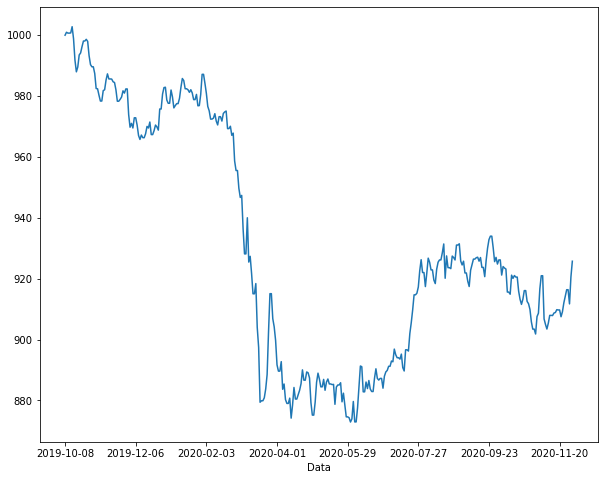

In [62]:
dfSMA['Saldo'].plot(figsize=(10,8))

In [63]:
dfSMA

,Saldo,Close,SMA_50,SMA_20,yesterday price,change,retorno,invisted sma
Data,,,,,,,,
2019-10-08,1000.00,0.99584,0.987137,0.993103,0.99293,1.002931,1.009131,1
2019-10-09,1000.97,0.99681,0.987690,0.993316,0.99584,1.000974,1.010114,1
2019-10-10,1000.69,0.99653,0.988091,0.993495,0.99681,0.999719,1.009831,1
2019-10-11,1000.69,0.99653,0.988558,0.993462,0.99653,1.000000,1.009831,1
2019-10-13,1000.75,0.99659,0.988965,0.993673,0.99653,1.000060,1.009891,1
...,...,...,...,...,...,...,...,...
2020-11-26,916.39,0.90389,0.911513,0.909809,0.90604,0.997627,NaN,-1
2020-11-27,916.39,0.90389,0.911220,0.909822,0.90389,1.000000,NaN,-1
2020-11-29,911.73,0.90855,0.910992,0.910284,0.90389,1.005155,NaN,-1


# Métricas SMA

In [64]:
dfSMA['Retorno']=dfSMA['Saldo'].pct_change()
dfSMA['R. Acumulado'] = (1+dfSMA['Retorno']).cumprod()
dfSMA['Retorno'].iloc[0] = 0
dfSMA['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_SMA = (dfSMA['Retorno'].mean()*(255-0.01))/(dfSMA['Retorno'].std()*np.sqrt(255))
print(Sharpe_SMA)

-0.7952048625205238


In [66]:
#Retorno anualizado
Retorno_anualizadoSMA= (1+dfSMA['Retorno'].sum())**0.5
print(Retorno_anualizadoSMA)

0.9622508990616793


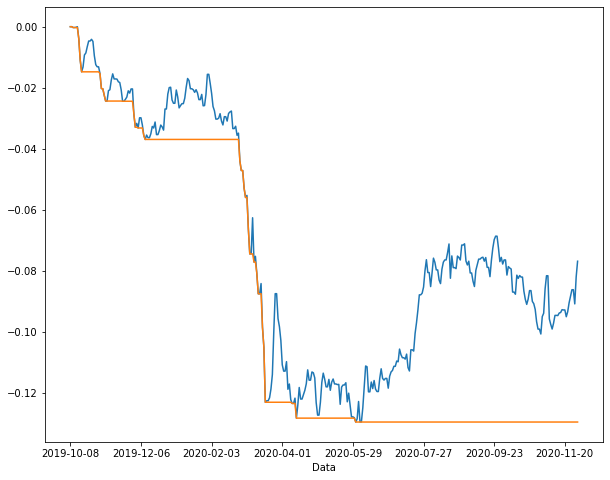

In [67]:
#MDD
Roll_Max2 = dfSMA['Saldo'].cummax()
Daily_Drawdown2 = dfSMA['Saldo']/Roll_Max2 - 1.0
MDDSMA = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSMA.plot(figsize=(10,8))

In [68]:
MDDSMA.min()

-0.1295173514160347

In [69]:
#Calmar
Calmar_SMA = (-dfSMA['Retorno'].mean()*255)/MDDSMA.min()
print(Calmar_SMA)

-0.40510805102151065


# Benchmark ATR

In [70]:
amostraATR= amostra

janela = 240
total=amostraATR.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosAtr=[]
diasAtr=[]
close=[]
sinal=[]
ATR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraATR.iloc[t:(janela)]
    inSample = amostraATR.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasAtr.extend(inSample.index)
    close.extend(inSample['Close'])
    ATR.extend(inSample['ATR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [71]:
dfATR = pd.DataFrame(diasAtr)
dfATR.columns=['Data']
dfATR.set_index('Data', inplace = True)
dfATR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfATR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfATR.insert(loc=2, column='ATR', value=ATR, allow_duplicates=False)
dfATR.insert(loc=3, column ='flag',value = 0, allow_duplicates=False)
saldo=1000

In [72]:
#logica trade ATR
saldo=1000
flag = 0
for i in np.arange(1,len(diasAtr)):
    
    if ATR[i]>0.008:
        flag = -1
        dfATR['flag'].iloc[i]= flag
    elif ATR[i] < 0.0065:
        flag = 1
        dfATR['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfATR['Close'].iloc[i]-dfATR['Close'].iloc[i-1])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfATR['Close'].iloc[i-1]-dfATR['Close'].iloc[i])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


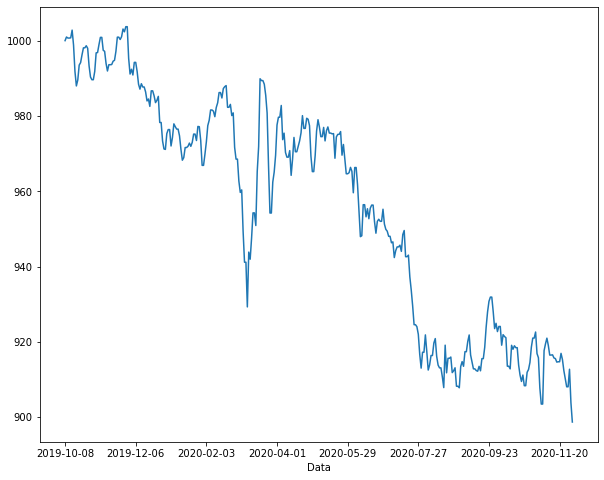

In [73]:
dfATR['Saldo'].plot(figsize=(10,8))


# Métricas ATR

In [74]:
dfATR['Retorno']=dfATR['Saldo'].pct_change()
dfATR['R. Acumulado'] = (1+dfATR['Retorno']).cumprod()
dfATR['Retorno'].iloc[0] = 0
dfATR['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [75]:
# Sharpe

Sharpe_ATR= (dfATR['Retorno'].mean()*(255-0.01))/(dfATR['Retorno'].std()*np.sqrt(255))
print(Sharpe_ATR)

-1.1573879948155357


In [76]:
# Retorno anualizado
Retorno_anualizadoATR= (1+dfATR['Retorno'].sum())**0.5
print(Retorno_anualizadoATR)

0.9465969938520912


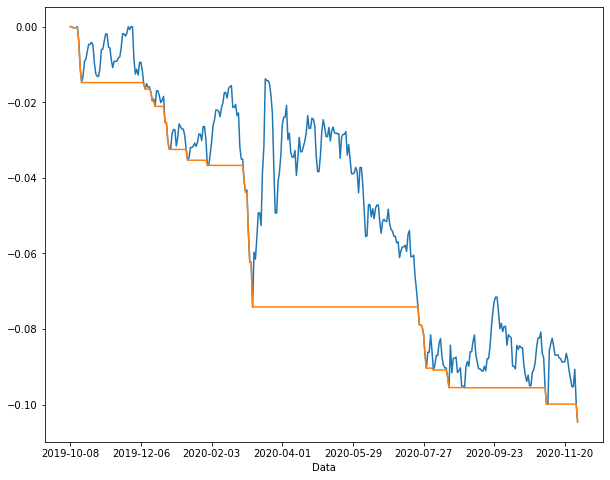

In [77]:
#MDD
Roll_Max2 = dfATR['Saldo'].cummax()
Daily_Drawdown2 = dfATR['Saldo']/Roll_Max2 - 1.0
MDDATR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDATR.plot(figsize=(10,8))

In [78]:
MDDATR.min()

-0.10463181596277782

In [79]:
#Calmar
Calmar_ATR = (-dfATR['Retorno'].mean()*255)/MDDATR.min()
print(Calmar_ATR)

-0.7037455635314793


# Benchmark SAR

In [80]:
amostrasar = amostra

janela = 240
total=amostrasar.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSar=[]
diasSar=[]
close=[]
sinal=[]
SAR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasar.iloc[t:(janela)]
    inSample = amostrasar.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSar.extend(inSample['body'])
    diasSar.extend(inSample.index)
    close.extend(inSample['Close'])
    SAR.extend(inSample['SAR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [81]:
dfSAR = pd.DataFrame(diasSar)
dfSAR.columns=['Data']
dfSAR.set_index('Data', inplace = True)
dfSAR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSAR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSAR.insert(loc=2, column='SAR', value=SAR, allow_duplicates=False)


In [82]:
saldo=1000
for i in np.arange(1,len(diasSma)):
    if SAR[i]< close[i]:
        saldo=saldo +(dfSAR['Close'].iloc[i]-dfSAR['Close'].iloc[i-1])*1000
        dfSAR['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSAR['Close'].iloc[i-1]-dfSAR['Close'].iloc[i])*1000
        dfSAR['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


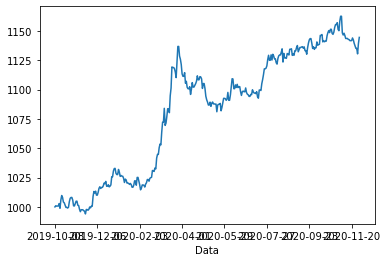

In [83]:
dfSAR['Saldo'].plot(fig=(10,8))

# Métricas SAR

In [84]:
dfSAR['Retorno']=dfSAR['Saldo'].pct_change()
dfSAR['R. Acumulado'] = (1+dfSAR['Retorno']).cumprod()

In [85]:
# Sharpe

Sharpe_SAR= (dfSAR['Retorno'].mean()*(255-0.01))/(dfSAR['Retorno'].std()*np.sqrt(255))
print(Sharpe_SAR)

1.7586212897530278


In [86]:
# Retorno anualizado
Retorno_anualizadoSAR= (1+dfSAR['Retorno'].sum())**0.5
print(Retorno_anualizadoSAR)

1.0663315591033966


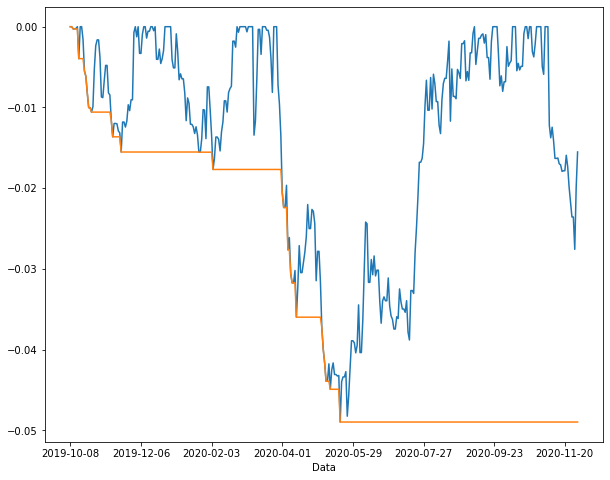

In [87]:
#MDD
Roll_Max2 = dfSAR['Saldo'].cummax()
Daily_Drawdown2 = dfSAR['Saldo']/Roll_Max2 - 1.0
MDDSAR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSAR.plot(figsize=(10,8))

In [88]:
MDDSAR.min()

-0.04895707788266146

In [89]:
#Calmar
Calmar_SAR = (-dfSAR['Retorno'].mean()*255)/MDDSAR.min()
print(Calmar_SAR)

1.9886138414612482


# Benchmark CCI

In [90]:
amostraCCI=amostra

janela = 240
total=amostraCCI.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosCci=[]
diasCci=[]
close=[]
sinal=[]
CCI=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraCCI.iloc[t:(janela)]
    inSample = amostraCCI.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosCci.extend(inSample['body'])
    diasCci.extend(inSample.index)
    close.extend(inSample['Close'])
    CCI.extend(inSample['CCI'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [91]:
dfCCI = pd.DataFrame(diasCci)
dfCCI.columns=['Data']
dfCCI.set_index('Data', inplace = True)
dfCCI.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfCCI.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfCCI.insert(loc=2, column='CCI', value=CCI, allow_duplicates=False)
dfCCI.insert(loc=3, column='flag',value=0,allow_duplicates=False)

In [92]:
saldo=1000
flag = 0
for i in np.arange(1,len(diasCci)):
    
    if CCI[i]>100:
        flag = 1
        dfCCI['flag'].iloc[i]= flag
    elif CCI[i] < -100:
        flag = -1
        dfCCI['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfCCI['Close'].iloc[i]-dfCCI['Close'].iloc[i-1])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfCCI['Close'].iloc[i-1]-dfCCI['Close'].iloc[i])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


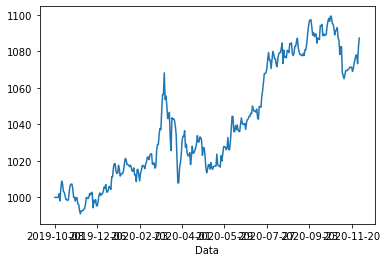

In [93]:
dfCCI['Saldo'].plot(fig=(10,8))

# Métricas CCI

In [94]:
dfCCI['Retorno']=dfCCI['Saldo'].pct_change()
dfCCI['R. Acumulado'] = (1+dfCCI['Retorno']).cumprod()
dfCCI['Retorno'].iloc[0] = 0
dfCCI['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [95]:
# Sharpe

Sharpe_CCI= (dfCCI['Retorno'].mean()*(255-0.01))/(dfCCI['Retorno'].std()*np.sqrt(255))
print(Sharpe_CCI)

1.0503543259968156


In [96]:
# Retorno anualizado
Retorno_anualizadoCCI= (1+dfCCI['Retorno'].sum())**0.5
print(Retorno_anualizadoCCI)

1.0421799270567764


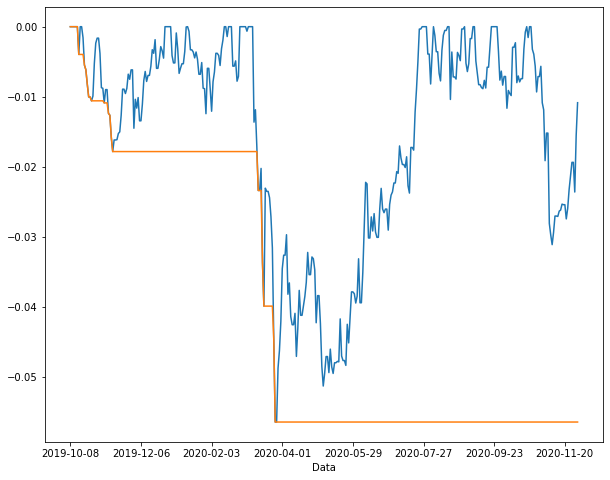

In [97]:
#MDD
Roll_Max2 = dfCCI['Saldo'].cummax()
Daily_Drawdown2 = dfCCI['Saldo']/Roll_Max2 - 1.0
MDDCCI = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDCCI.plot(figsize=(10,8))

In [98]:
MDDCCI.min()

-0.056446932394735194

In [99]:
#Calmar
Calmar_CCI= (-dfCCI['Retorno'].mean()*255)/MDDCCI.min()
print(Calmar_CCI)

1.0809289834984712


#  faz-se o tuning utilizando o grid_search para rodar o random forest sem a tunagem a cada passo


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parâmetros
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90 , 100, 110],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state':[0,42]
}
# instanciando o modelo
rf = RandomForestClassifier()
# Instanciando o grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [24]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    
    
    window= window+60
    print(grid_search.best_params_)
    print(acuracia)

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 55.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 42}
0.5333333333333333
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 0}
0.6
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5833333333333334
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 200, 'random_state': 42}
0.5666666666666667
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400, 'random_state': 42}
0.55


# agora pegando os parametros que apresentaram uma maior acurácia no grid_search , faz-se o walkforward com eles

In [123]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
rf = RandomForestClassifier(random_state= 0,bootstrap = True, max_depth = 50, max_features= 3, min_samples_leaf = 3, min_samples_split= 10, n_estimators = 200)


In [125]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]


In [126]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    rf.fit(X_treino,Y_treino)
    yrf_pred=rf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)
# 0.5333333333333333
# 0.5833333333333334
# 0.6166666666666667
# 0.5
# 0.6
# 0.55

0.6333333333333333
0.5166666666666667
0.65
0.5
0.4166666666666667
0.5833333333333334


# implementando a estratégia:

# defini de uma forma bem simples que o ganho/perda do dia seria a diferença de abertura - fechamento da vela
# se o valor predito fosse igual ao valor real da ordem ( 1 -> compra ; -1 -> venda), ele somaria os pips ao saldo caso estivesse correto ou subtrairia caso estivesse errado.



In [127]:
saldo = 1000


In [128]:
lucro = pd.DataFrame(dias)

In [129]:
lucro.columns=['Data']

In [130]:
lucro.set_index('Data', inplace = True)

In [131]:
lucro.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)

In [132]:
lucro.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [133]:
saldo=1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo     
       
    
#     print(saldo)

In [134]:
lucro

,Saldo
Data,
2019-10-08,1000.00
2019-10-09,1000.97
2019-10-10,1001.27
2019-10-11,1001.27
2019-10-13,1001.07
...,...
2020-11-26,1071.48
2020-11-27,1071.48
2020-11-29,1076.12


In [135]:
lucro['Retorno']=lucro['Saldo'].pct_change()

In [136]:
lucro['R. Acumulado'] = (1+lucro['Retorno']).cumprod()

In [137]:
lucro['Retorno'].iloc[0] = 0
lucro['R. Acumulado'].iloc[0]=0

In [138]:
lucro.head()

,Saldo,Retorno,R. Acumulado
Data,,,
2019-10-08,1000.00,0.00000,0.00000
2019-10-09,1000.97,0.00097,1.00097
2019-10-10,1001.27,0.00030,1.00127
2019-10-11,1001.27,0.00000,1.00127
2019-10-13,1001.07,-0.00020,1.00107


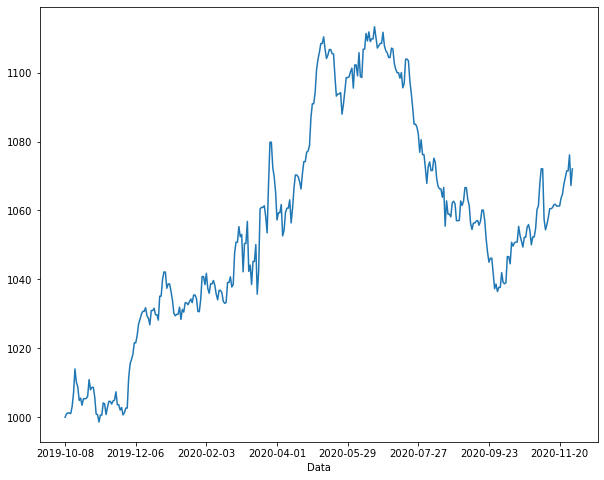

In [139]:
lucro['Saldo'].plot(figsize=(10,8))

In [36]:
lucro.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


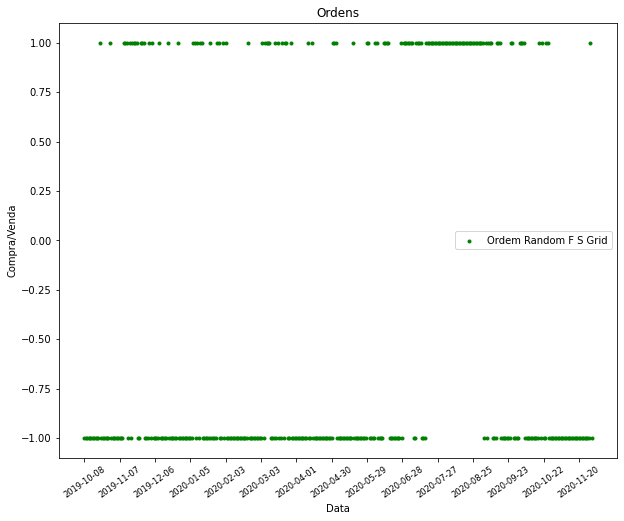

In [165]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (10,8))
plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.plot(lucro['Saldo'], label='Retorno', alpha =0.35)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

# Métricas de desempenho


# Índice de Sharpe


In [37]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio1 = (lucro['Retorno'].mean()*(255-0.01) )/(lucro['Retorno'].std()*np.sqrt(255)) # mean = return_series.mean() * N -rf
print(Sharpe_Ratio1)

0.9011684876574113


# Retorno anualizado

In [38]:
Retorno_anualizado1 = (1+lucro['Retorno'].sum())**0.5

In [39]:
print(Retorno_anualizado1)

1.0352933221060145


# Máximo Drawdown

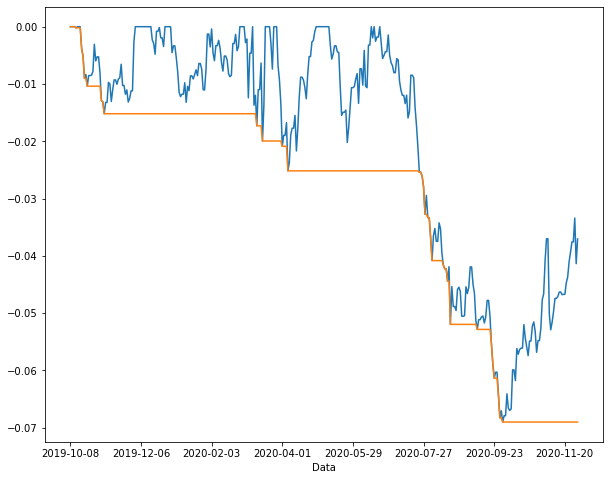

In [40]:
Roll_Max1 = lucro['Saldo'].cummax()
Daily_Drawdown1 = lucro['Saldo']/Roll_Max1 - 1.0
MDD1 = Daily_Drawdown1.cummin()
# Plotando o resultado
Daily_Drawdown1.plot(figsize =(10,8))
MDD1.plot(figsize=(10,8))

In [41]:
MDD1.min()

-0.06901941058644923

# Índice de Calmar

In [42]:
Calmar_Ratio1 = (-lucro['Retorno'].mean()*255)/MDD1.min()
print(Calmar_Ratio1)

0.7372011107565575


# Calculando o walkforward com o grid_search a cada passo

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state': [0, 42]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [23]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    

    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished


0.5333333333333333
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.3min finished


0.5833333333333334
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6666666666666666
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.5min finished


0.5333333333333333
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished


0.4666666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.4min finished


0.6


# Calculando retornos com WFA com grid search a cada passo

In [24]:
saldo = 1000


In [25]:
lucroWFA = pd.DataFrame(dias)
lucroWFA.columns=['Data']
lucroWFA.set_index('Data', inplace = True)
lucroWFA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroWFA.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [26]:
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo  

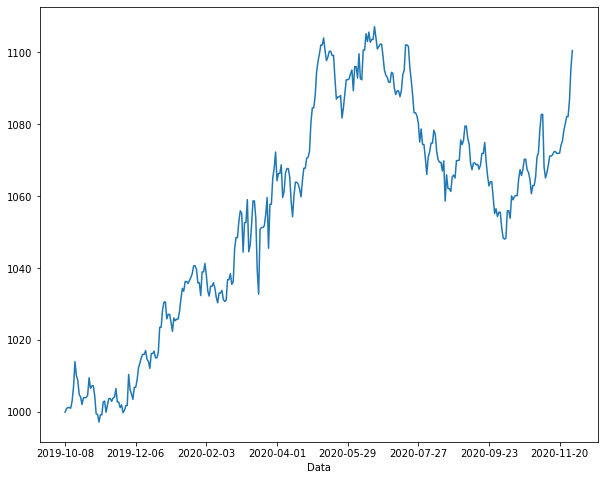

In [27]:
lucroWFA['Retorno']=lucroWFA['Saldo'].pct_change()
lucroWFA['R. Acumulado'] = (1+lucroWFA['Retorno']).cumprod()
lucroWFA['Retorno'].iloc[0] = 0
lucroWFA['R. Acumulado'].iloc[0]=0
lucroWFA['Saldo'].plot(figsize=(10,8))

In [28]:
lucroWFA.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [29]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,1000.97,0.000970,1.00097
2019-10-10,-1,1001.27,0.000300,1.00127
2019-10-11,-1,1001.27,0.000000,1.00127
2019-10-13,-1,1001.07,-0.000200,1.00107
...,...,...,...,...
2020-11-26,-1,1082.16,0.001861,1.08216
2020-11-27,-1,1082.16,0.000000,1.08216
2020-11-29,-1,1086.80,0.004288,1.08680


# Métricas de desempenho


# Índice de Sharpe

In [30]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio2 = (lucroWFA['Retorno'].mean()*(255-0.01))/(lucroWFA['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio2)

1.2311983849827397


# Retorno anualizado

In [31]:
Retorno_anualizado2 = (1+lucroWFA['Retorno'].sum())**0.5
print(Retorno_anualizado2)

1.0478536321969574


# Máximo Drawdown

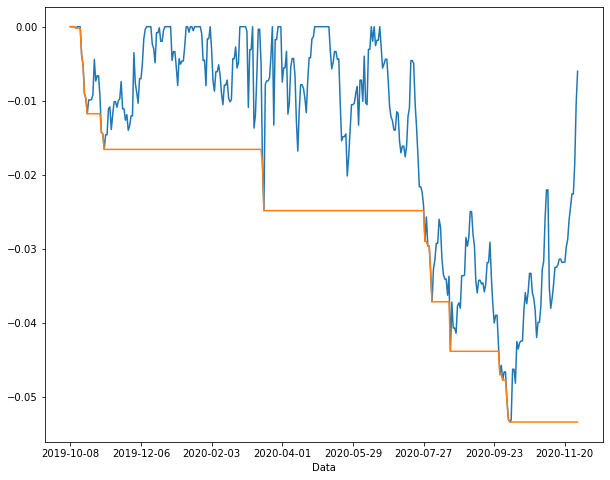

In [32]:
Roll_Max2 = lucroWFA['Saldo'].cummax()
Daily_Drawdown2 = lucroWFA['Saldo']/Roll_Max2 - 1.0
MDD2 = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDD2.plot(figsize=(10,8))

In [33]:
MDD2.min()

-0.053353204172876145

# Índice de Calmar

In [34]:
Calmar_Ratio2 = (-lucroWFA['Retorno'].mean()*255)/MDD2.min()
print(Calmar_Ratio2)

1.30104103123467


In [35]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,1000.97,0.000970,1.00097
2019-10-10,-1,1001.27,0.000300,1.00127
2019-10-11,-1,1001.27,0.000000,1.00127
2019-10-13,-1,1001.07,-0.000200,1.00107
...,...,...,...,...
2020-11-26,-1,1082.16,0.001861,1.08216
2020-11-27,-1,1082.16,0.000000,1.08216
2020-11-29,-1,1086.80,0.004288,1.08680


# Fazendo o benchmark com o MACD

# Arrumando os dias da amostra

In [100]:
#tamanho da amostra
amostraMACD = amostra

# Calculando o MACD


In [101]:
# Calculando a EMA com período menor
ShortEMA = amostraMACD['Close'].ewm(span =12, adjust = False).mean()
# Calculando a EMA com período maior
LongEMA = amostraMACD['Close'].ewm(span = 26, adjust = False).mean()
# Calculando o sinal MACD
MACD = ShortEMA - LongEMA
# Calculando a linha do sinal
sinal = MACD.ewm(span = 9, adjust = False).mean()


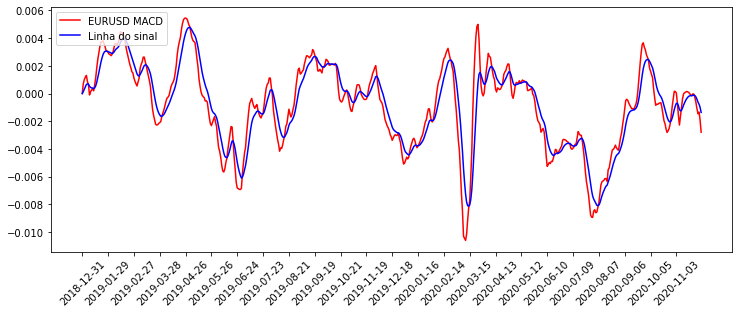

In [102]:
#plotando o gráfico
plt.figure(figsize = (12.2 , 4.5))
plt.plot(amostraMACD.index, MACD, label='EURUSD MACD', color = 'red')
plt.plot(amostraMACD.index, sinal, label = 'Linha do sinal', color = 'blue')
plt.xticks(amostraMACD.index[::25],rotation = 45)
plt.legend(loc='upper left')
plt.show()


# Adicionando a coluna com os valores do MACD no dataframe amostraMACD

In [103]:
amostraMACD['MACD'] = MACD
amostraMACD['Linha de Sinal'] = sinal
#visualizando os dados
amostraMACD.head()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_95,return_96,lag_return_96,sobe_desce,price yesterday,change,invested_SMA,retorno,MACD,Linha de Sinal
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.98099,0.98099,0.98099,0.98099,0.0000,0.0,0.0,0.0,0.995617,0.990398,...,-0.001543,0.009114,-0.002872,1,NaN,NaN,-1,NaN,0.000000,0.000000
2019-01-01,0.98120,0.99200,0.97960,0.99000,123098.3795,88.0,20.0,16.0,0.995329,0.990384,...,-0.005440,0.019956,-0.001543,-1,0.98099,1.009185,-1,NaN,0.000719,0.000144
2019-01-02,0.99000,0.99087,0.98459,0.98669,165175.6400,-33.1,8.7,21.0,0.995015,0.990060,...,0.001927,0.022106,-0.005440,-1,0.99000,0.996657,-1,NaN,0.001010,0.000317
2019-01-03,0.98660,0.99078,0.98528,0.98616,142161.0608,-4.4,41.8,8.8,0.994700,0.989695,...,0.000000,0.019592,0.001927,-1,0.98669,0.999463,-1,NaN,0.001184,0.000490
2019-01-04,0.98616,0.98616,0.98616,0.98616,0.0000,0.0,0.0,0.0,0.994306,0.989305,...,-0.004839,0.019592,0.000000,-1,0.98616,1.000000,-1,NaN,0.001307,0.000654


In [104]:
#logica MACD para trade
amostraMACD['price yesterday'] = amostraMACD['Close'].shift(1)
amostraMACD['change'] = (amostraMACD['Close']/amostraMACD['price yesterday'])

amostraMACD['invested_MACD'] = [1 if amostraMACD.loc[i,'MACD'] > amostraMACD.loc[i,'Linha de Sinal'] else -1 for i in amostraMACD.index]
MACD=amostraMACD[amostraMACD['invested_MACD']==1]
amostraMACD['retorno']=np.cumprod(MACD['change'])


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Criando a função que sinalizará a compra ou venda 

In [105]:
def buy_sell(sinal):
    buy = []
    sell = []
    flag = -1
    
    for i in range(0,len(sinal)):
        if sinal['MACD'][i] > sinal['Linha de Sinal'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(sinal['Close'][i])
                flag = 1
            else:
                buy.append(np.nan)

        elif sinal['MACD'][i] < sinal['Linha de Sinal'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(sinal['Close'][i])
                flag = 0
            else:
                sell.append(np.nan) 
        else:
            sell.append(np.nan)
            buy.append(np.nan)
    return (buy,sell)

In [106]:
# criando as colunas buy e sell
a = buy_sell(amostraMACD)
amostraMACD['Preço para Buy'] = a[0]
amostraMACD['Preço para Sell'] = a[1]

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


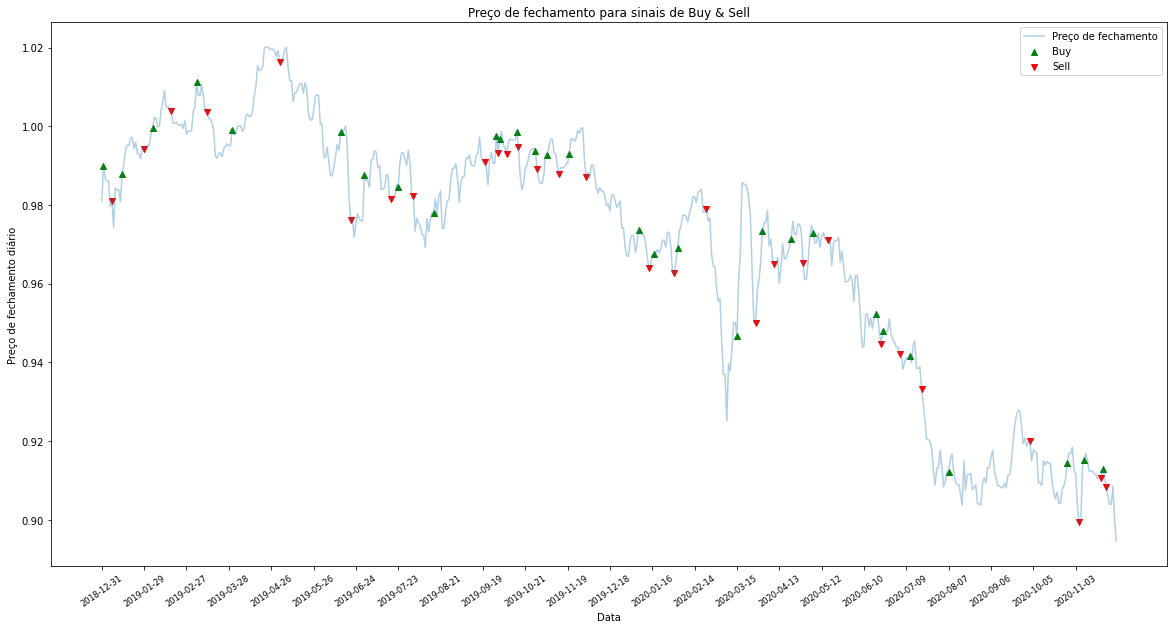

In [107]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(amostraMACD.index, amostraMACD['Preço para Buy'], color = 'green', label = 'Buy', marker = '^', alpha=1)
plt.scatter(amostraMACD.index, amostraMACD['Preço para Sell'], color = 'red', label = 'Sell', marker = 'v', alpha=1)

plt.plot(amostraMACD['Close'], label='Preço de fechamento', alpha =0.35)
plt.title('Preço de fechamento para sinais de Buy & Sell')
plt.xticks(amostraMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Preço de fechamento diário')
plt.legend( loc = 'upper right')
plt.show()

# Separando os dias de operações conforme o walkforward

In [108]:
janela = 240
total=amostraMACD.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward


In [109]:
#listas para receberem valores
pontosMacd=[]
diasMacd=[]
buy =[]
sell= []
close=[]
sinal=[]
MACDl=[]
yprice=[]
change=[]
invistedMACD=[]
retorno=[]

In [110]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraMACD.iloc[t:(janela)]
    inSample = amostraMACD.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosMacd.extend(inSample['body'])
    diasMacd.extend(inSample.index)
    buy.extend(inSample['Preço para Buy'])
    sell.extend(inSample['Preço para Sell'])
    close.extend(inSample['Close'])
    sinal.extend(inSample['Linha de Sinal'])  
    MACDl.extend(inSample['MACD'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedMACD.extend(inSample['invested_MACD'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [111]:
#criação do dataframe para calculo de retornos
dfMACD = pd.DataFrame(diasMacd)
dfMACD.columns=['Data']
dfMACD.set_index('Data', inplace = True)
dfMACD.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfMACD.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfMACD.insert(loc=2, column='MACD', value=MACDl, allow_duplicates=False)
dfMACD.insert(loc=3, column='Linha de Sinal', value=sinal, allow_duplicates=False)
dfMACD.insert(loc=4, column='Buy', value=buy, allow_duplicates=False)
dfMACD.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfMACD.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfMACD.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfMACD.insert(loc=7, column='invisted macd', value=invistedMACD, allow_duplicates=False)


In [112]:
saldo = 1000

In [113]:
dfMACD.head(50)

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-08,1000,0.99584,0.002055,0.002126,0.99293,1.002931,NaN,-1,NaN
2019-10-09,1000,0.99681,0.002117,0.002125,0.99584,1.000974,NaN,-1,NaN
2019-10-10,1000,0.99653,0.002120,0.002124,0.99681,0.999719,NaN,-1,NaN
2019-10-11,1000,0.99653,0.002097,0.002118,0.99653,1.000000,NaN,-1,NaN
2019-10-13,1000,0.99659,0.002061,0.002107,0.99653,1.000060,NaN,-1,NaN
2019-10-14,1000,0.99864,0.002172,0.002120,0.99659,1.002057,1.057376,1,0.99864
2019-10-15,1000,0.99467,0.001918,0.002080,0.99864,0.996025,NaN,-1,NaN
2019-10-16,1000,0.98766,0.001138,0.001891,0.99467,0.992952,NaN,-1,NaN
2019-10-17,1000,0.98381,0.000206,0.001554,0.98766,0.996102,NaN,-1,NaN


In [114]:
saldo=1000

for i in np.arange(1,len(diasMacd)):
    if invistedMACD[i]==1:
        saldo=saldo+(((dfMACD['Close'].iloc[i]-dfMACD['yesterday price'].iloc[i]))*(1000))
        dfMACD['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + ((dfMACD['yesterday price'].iloc[i]-dfMACD['Close'].iloc[i]))*(1000)
        dfMACD['Saldo'].iloc[i]=saldo   
            

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [115]:
dfMACD.head(50)


,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-08,1000.00,0.99584,0.002055,0.002126,0.99293,1.002931,NaN,-1,NaN
2019-10-09,999.03,0.99681,0.002117,0.002125,0.99584,1.000974,NaN,-1,NaN
2019-10-10,999.31,0.99653,0.002120,0.002124,0.99681,0.999719,NaN,-1,NaN
2019-10-11,999.31,0.99653,0.002097,0.002118,0.99653,1.000000,NaN,-1,NaN
2019-10-13,999.25,0.99659,0.002061,0.002107,0.99653,1.000060,NaN,-1,NaN
2019-10-14,1001.30,0.99864,0.002172,0.002120,0.99659,1.002057,1.057376,1,0.99864
2019-10-15,1005.27,0.99467,0.001918,0.002080,0.99864,0.996025,NaN,-1,NaN
2019-10-16,1012.28,0.98766,0.001138,0.001891,0.99467,0.992952,NaN,-1,NaN
2019-10-17,1016.13,0.98381,0.000206,0.001554,0.98766,0.996102,NaN,-1,NaN


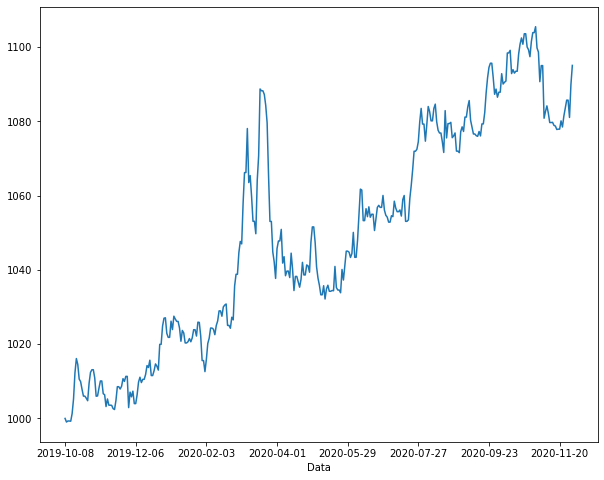

In [116]:
dfMACD['Saldo'].plot(figsize=(10,8))

In [117]:
#calculando o retorno
dfMACD['Retorno']=dfMACD['Saldo'].pct_change()
dfMACD['R. Acumulado'] = (dfMACD['Retorno']).cumprod()

In [118]:
dfMACD

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy,Retorno,R. Acumulado
Data,,,,,,,,,,,
2019-10-08,1000.00,0.99584,0.002055,0.002126,0.99293,1.002931,NaN,-1,NaN,NaN,NaN
2019-10-09,999.03,0.99681,0.002117,0.002125,0.99584,1.000974,NaN,-1,NaN,-0.000970,-9.700000e-04
2019-10-10,999.31,0.99653,0.002120,0.002124,0.99681,0.999719,NaN,-1,NaN,0.000280,-2.718637e-07
2019-10-11,999.31,0.99653,0.002097,0.002118,0.99653,1.000000,NaN,-1,NaN,0.000000,-0.000000e+00
2019-10-13,999.25,0.99659,0.002061,0.002107,0.99653,1.000060,NaN,-1,NaN,-0.000060,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,1085.73,0.90389,-0.001121,-0.000428,0.90604,0.997627,NaN,-1,NaN,0.001984,-0.000000e+00
2020-11-27,1085.73,0.90389,-0.001462,-0.000634,0.90389,1.000000,NaN,-1,NaN,0.000000,-0.000000e+00
2020-11-29,1081.07,0.90855,-0.001340,-0.000776,0.90389,1.005155,NaN,-1,NaN,-0.004292,0.000000e+00


# Calculando as métricas de desempenho

# Índice de Sharpe

In [170]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio3 = (dfMACD['Retorno'].mean()*(255-0.01)) /(dfMACD['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio3)

1.15392399075064


# Retorno Anualizado

In [171]:
Retorno_anualizado3 = (1+dfMACD['Retorno'].sum())**0.5
print(Retorno_anualizado3)

1.0455406702335284


# Máximo Drawdown

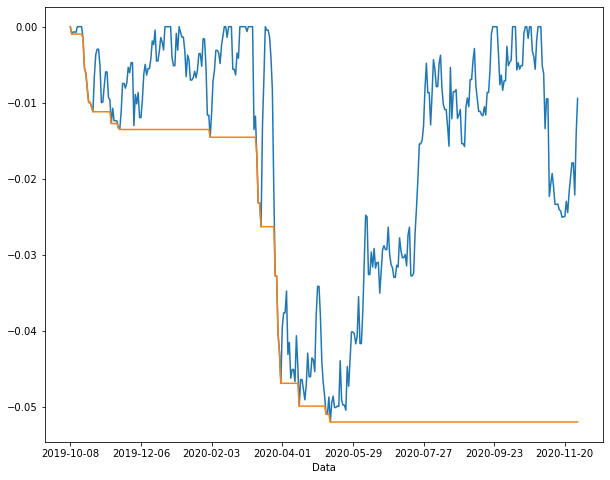

In [172]:
Roll_Max3 = dfMACD['Saldo'].cummax()
Daily_Drawdown3 = dfMACD['Saldo']/Roll_Max3 - 1.0
MDD3 = Daily_Drawdown3.cummin()
# Plotando o resultado
Daily_Drawdown3.plot(figsize =(10,8))
MDD3.plot(figsize=(10,8))

In [173]:
MDD3.min()

-0.051959145434171794

# Índice de Calmar

In [174]:
Calmar_Ratio3 = -(dfMACD['Retorno'].mean()*255)/MDD3.min()
print(Calmar_Ratio3)

1.2734774785353677


# Testando para SVM

# Primeiro utilizando o SVM sem o grid_search()

In [37]:
#fazendo os imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [38]:
amostra

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.98099,0.98099,0.98099,0.98099,0.0000,0.0,0.0,0.0,0.995617,0.990398,...,0.000000,0.014247,0.001927,0.016201,-0.005440,0.010673,-0.001543,0.009114,-0.002872,1
2019-01-01,0.98120,0.99200,0.97960,0.99000,123098.3795,88.0,20.0,16.0,0.995329,0.990384,...,-0.004839,0.023563,0.000000,0.023563,0.001927,0.025535,-0.005440,0.019956,-0.001543,-1
2019-01-02,0.99000,0.99087,0.98459,0.98669,165175.6400,-33.1,8.7,21.0,0.995015,0.990060,...,0.002036,0.025101,-0.004839,0.020140,0.000000,0.020140,0.001927,0.022106,-0.005440,-1
2019-01-03,0.98660,0.99078,0.98528,0.98616,142161.0608,-4.4,41.8,8.8,0.994700,0.989695,...,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,0.019592,0.001927,-1
2019-01-04,0.98616,0.98616,0.98616,0.98616,0.0000,0.0,0.0,0.0,0.994306,0.989305,...,-0.008531,0.019751,0.002665,0.022468,0.002036,0.024550,-0.004839,0.019592,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,0.90590,0.90825,0.90389,0.90389,60744.1202,-20.1,23.5,0.0,0.911513,0.909809,...,-0.005171,-0.013974,0.001278,-0.012714,0.003651,-0.009110,0.000000,-0.009110,0.002748,-1
2020-11-27,0.90389,0.90389,0.90389,0.90389,0.0000,0.0,0.0,0.0,0.911220,0.909822,...,-0.002522,-0.008849,-0.005171,-0.013974,0.001278,-0.012714,0.003651,-0.009110,0.000000,1
2020-11-29,0.90391,0.90925,0.90189,0.90855,68207.0409,46.4,7.0,20.2,0.910992,0.910284,...,-0.000813,-0.001220,-0.002522,-0.003739,-0.005171,-0.008891,0.001278,-0.007624,0.003651,-1


In [39]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [40]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

In [41]:
clf = make_pipeline(StandardScaler(), SVC(C= 1, gamma= 'auto', kernel= 'rbf'))

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    clf.fit(X_treino,Y_treino)
    yrf_pred=clf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)

0.5333333333333333
0.55
0.6166666666666667
0.4166666666666667
0.5666666666666667
0.6


# Calculando os retornos

In [42]:
lucroSvm = pd.DataFrame(dias)
lucroSvm.columns=['Data']
lucroSvm.set_index('Data', inplace = True)
lucroSvm.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvm.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [43]:
saldo =1000

In [44]:

for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo 

In [45]:
lucroSvm

,Saldo
Data,
2019-10-08,1000.00
2019-10-09,1000.97
2019-10-10,1001.27
2019-10-11,1001.27
2019-10-13,1001.07
...,...
2020-11-26,1146.78
2020-11-27,1146.78
2020-11-29,1142.14


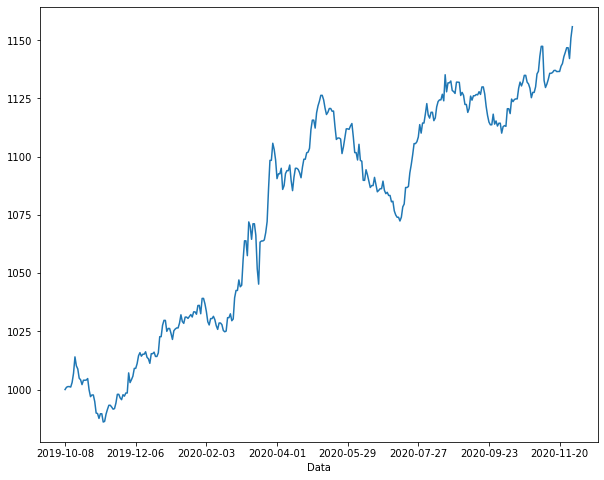

In [46]:
lucroSvm['Retorno']=lucroSvm['Saldo'].pct_change()
lucroSvm['R. Acumulado'] = (1+lucroSvm['Retorno']).cumprod()
lucroSvm['Retorno'].iloc[0] = 0
lucroSvm['R. Acumulado'].iloc[0]=0
lucroSvm['Saldo'].plot(figsize=(10,8))

In [47]:
lucroSvm.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [48]:
lucroSvm

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,1000.97,0.000970,1.00097
2019-10-10,-1,1001.27,0.000300,1.00127
2019-10-11,-1,1001.27,0.000000,1.00127
2019-10-13,-1,1001.07,-0.000200,1.00107
...,...,...,...,...
2020-11-26,-1,1146.78,0.001756,1.14678
2020-11-27,-1,1146.78,0.000000,1.14678
2020-11-29,1,1142.14,-0.004046,1.14214


# Métricas de desempenho


# Índice de Sharpe

In [89]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio4 =( lucroSvm['Retorno'].mean()*(255-0.01)) /(lucroSvm['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio4)

1.890532768754526


# Retorno anualizado

In [90]:
Retorno_anualizado4 = (1+lucroSvm['Retorno'].sum())**0.5
print(Retorno_anualizado4)

1.0709670706656895


# Máximo Drawdown

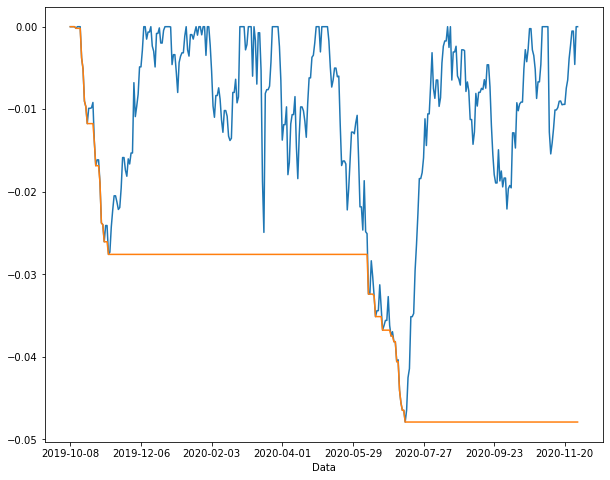

In [91]:
Roll_Max4 = lucroSvm['Saldo'].cummax()
Daily_Drawdown4 = lucroSvm['Saldo']/Roll_Max4 - 1.0
MDD4 = Daily_Drawdown4.cummin()
# Plotando o resultado
Daily_Drawdown4.plot(figsize =(10,8))
MDD4.plot(figsize=(10,8))

In [92]:
MDD4.min()

-0.04790738143011841

# Índice de Calmar

In [93]:
Calmar_Ratio4 = -lucroSvm['Retorno'].mean()*255/MDD4.min()
print(Calmar_Ratio4)

2.1730279822142595


# Testando SVM com grid_search a cada passo do WFA

In [49]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [50]:
C = [x for x in np.logspace(start = 2**-15, stop = 2**5)]
gamma =  [x for x in np.logspace(start = 2**-15, stop = 2**3)]

In [51]:
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parâmetros
param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['rbf']} 
# Instanciando o modelo de machine learning
clf = SVC()
# Instanciando o grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [52]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor

    grid_search.fit(X_treino, Y_treino)
    clf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, clf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(clf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)
    print(grid_search.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 900 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 4788 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   48.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.55
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   45.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5166666666666667
{'C': 1.0000702717894114, 'gamma': 1.4564487290670938, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5833333333333334
{'C': 1.0000702717894114, 'gamma': 3.0890473653058805, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5833333333333334
{'C': 1.0000702717894114, 'gamma': 62.50892555726168, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   49.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.65
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   30.5s


0.6833333333333333
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   46.0s finished


# Calculando os retornos

In [53]:
lucroSvmg = pd.DataFrame(dias)
lucroSvmg.columns=['Data']
lucroSvmg.set_index('Data', inplace = True)
lucroSvmg.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvmg.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [54]:
saldo =1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo 

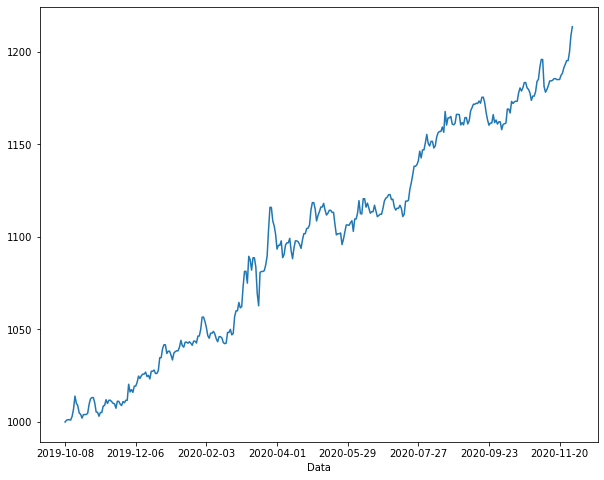

In [55]:
lucroSvmg['Retorno']=lucroSvmg['Saldo'].pct_change()
lucroSvmg['R. Acumulado'] = (1+lucroSvmg['Retorno']).cumprod()
lucroSvmg['Retorno'].iloc[0] = 0
lucroSvmg['R. Acumulado'].iloc[0]=0
lucroSvmg['Saldo'].plot(figsize=(10,8))

In [56]:
lucroSvmg.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [57]:
lucroSvmg

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,1000.97,0.000970,1.00097
2019-10-10,-1,1001.27,0.000300,1.00127
2019-10-11,-1,1001.27,0.000000,1.00127
2019-10-13,-1,1001.07,-0.000200,1.00107
...,...,...,...,...
2020-11-26,-1,1195.20,0.001685,1.19520
2020-11-27,-1,1195.20,0.000000,1.19520
2020-11-29,-1,1199.84,0.003882,1.19984


# Métricas de Desempenho

# Índice de Sharpe

In [103]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio5 = ((255-0.01)*lucroSvmg['Retorno'].mean()) /(lucroSvmg['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio5)

2.578356736576344


# Retorno Anualizado

In [104]:
Retorno_anualizado5 = (1+lucroSvmg['Retorno'].sum())**0.5
print(Retorno_anualizado5)

1.0934381546687586


# Máximo Drawdown

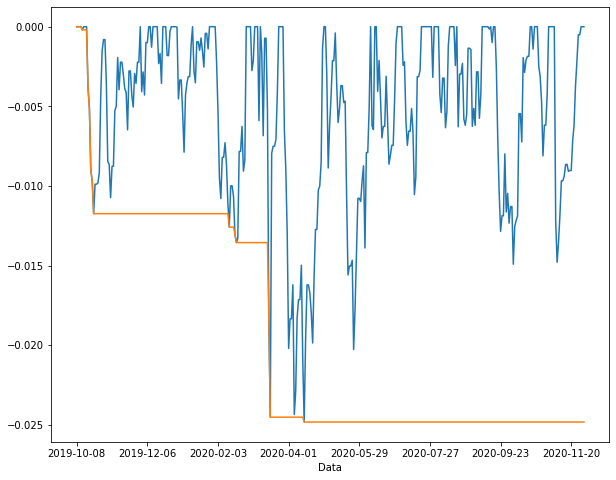

In [105]:
Roll_Max5 = lucroSvmg['Saldo'].cummax()
Daily_Drawdown5 = lucroSvmg['Saldo']/Roll_Max5 - 1.0
MDD5 = Daily_Drawdown5.cummin()
# Plotando o resultado
Daily_Drawdown5.plot(figsize =(10,8))
MDD5.plot(figsize=(10,8))

In [106]:
MDD5.min()

-0.02483108410846424

# Índice de Calmar

In [107]:
Calmar_Ratio5 = -(lucroSvmg['Retorno'].mean()*255)/MDD5.min()
print(Calmar_Ratio5)

5.579899627899978


# Gráfico retornos

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


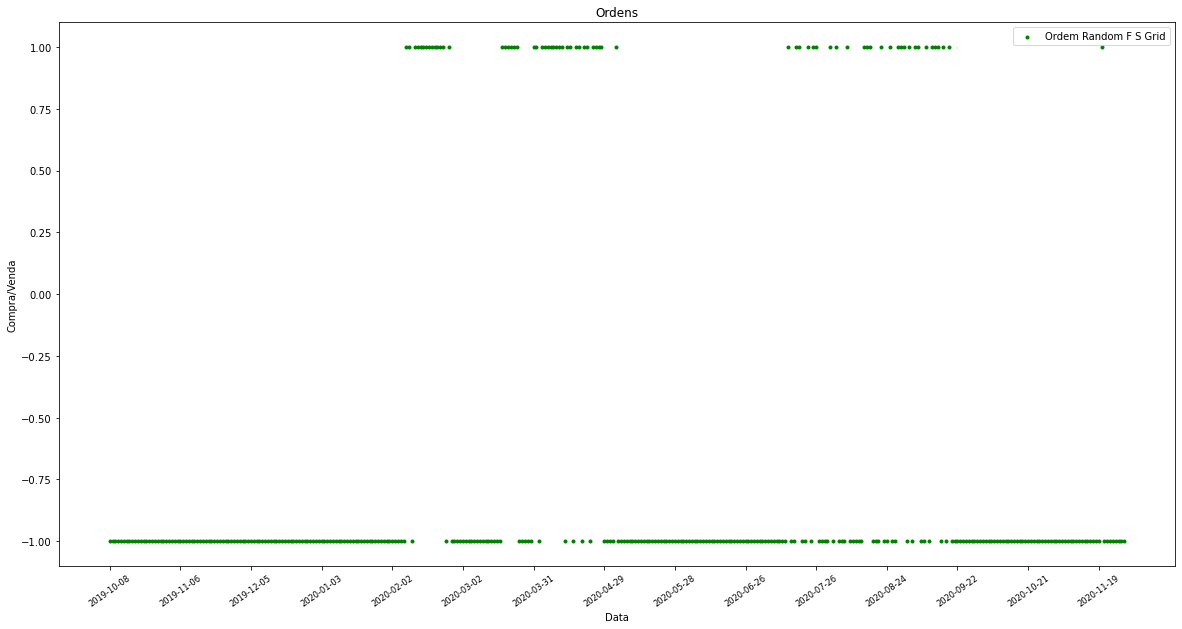

In [204]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


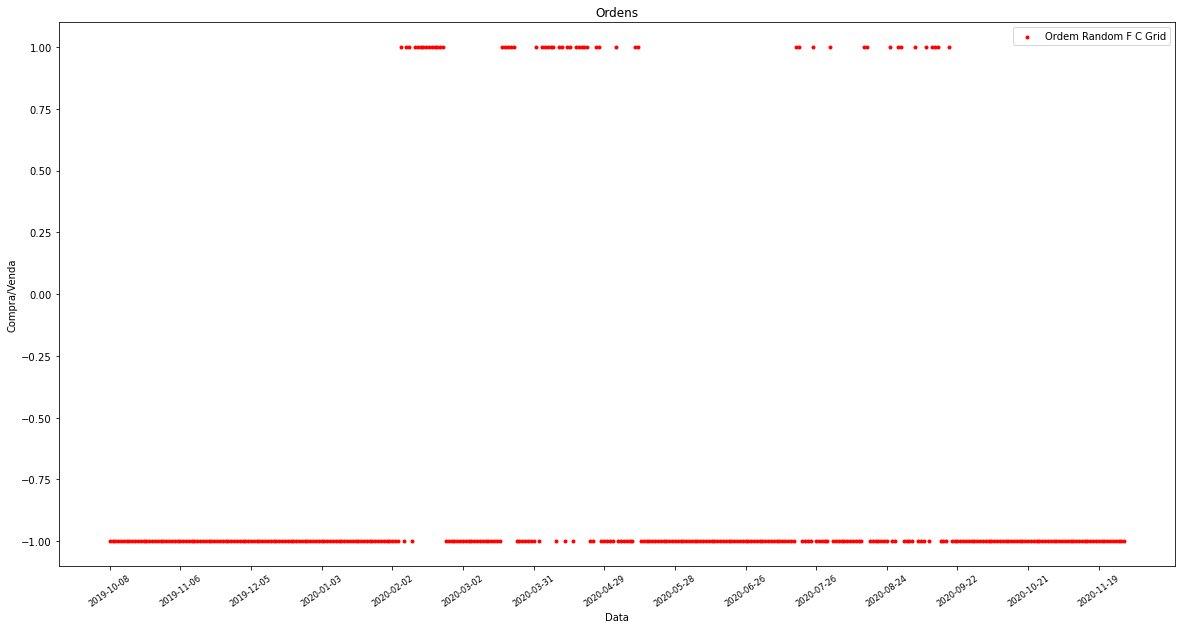

In [92]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


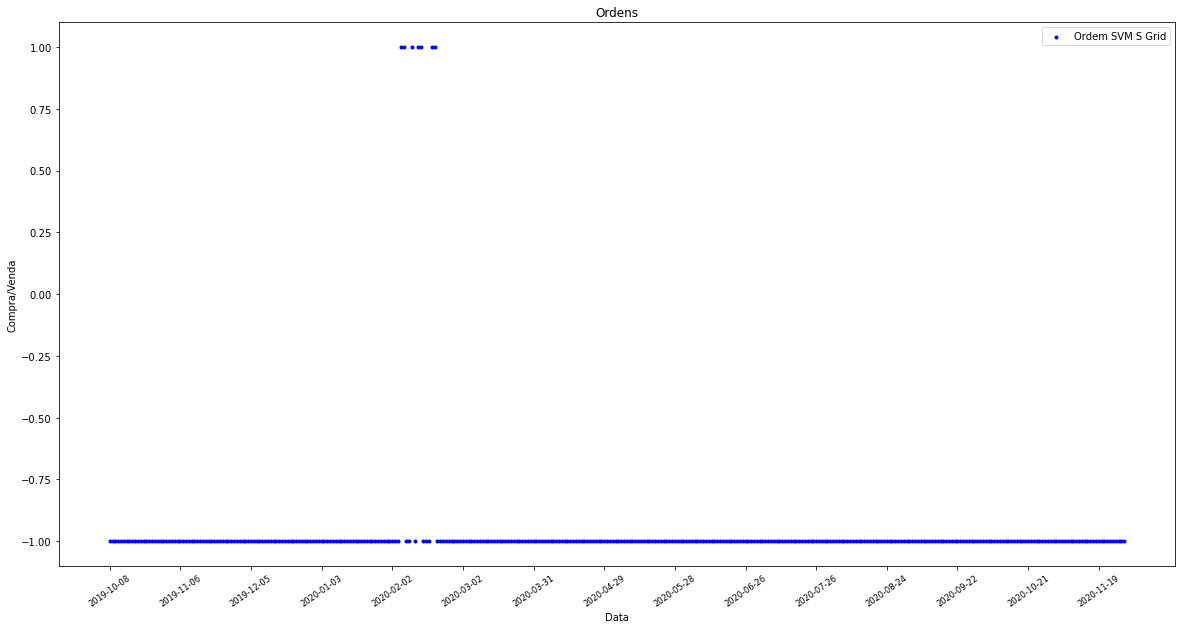

In [274]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


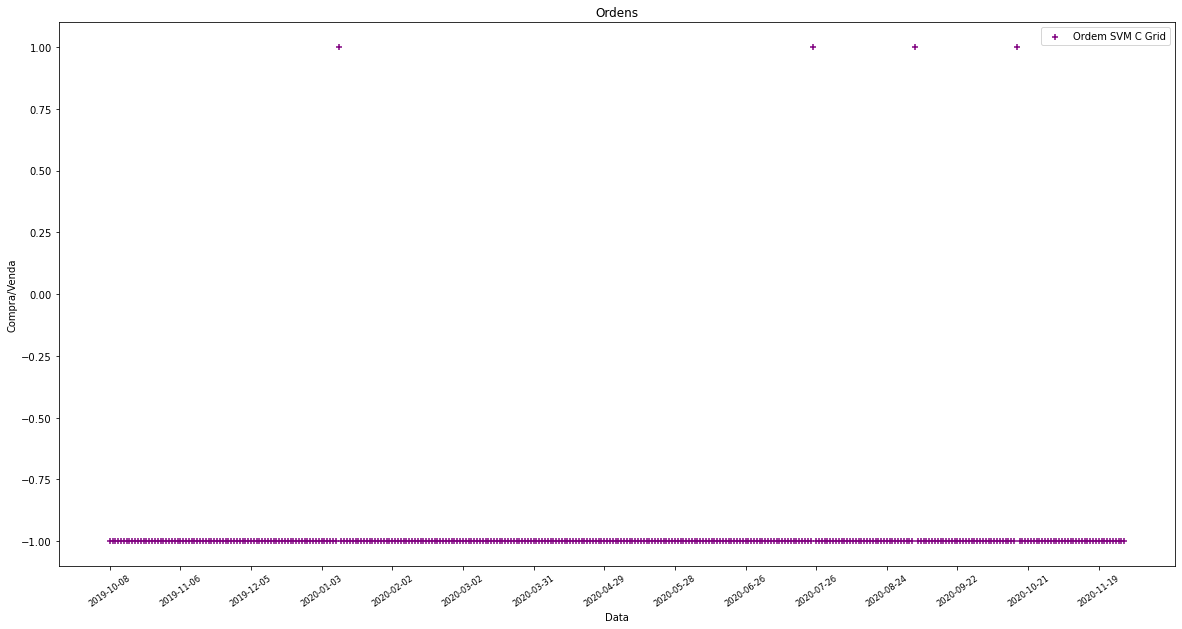

In [227]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '.', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


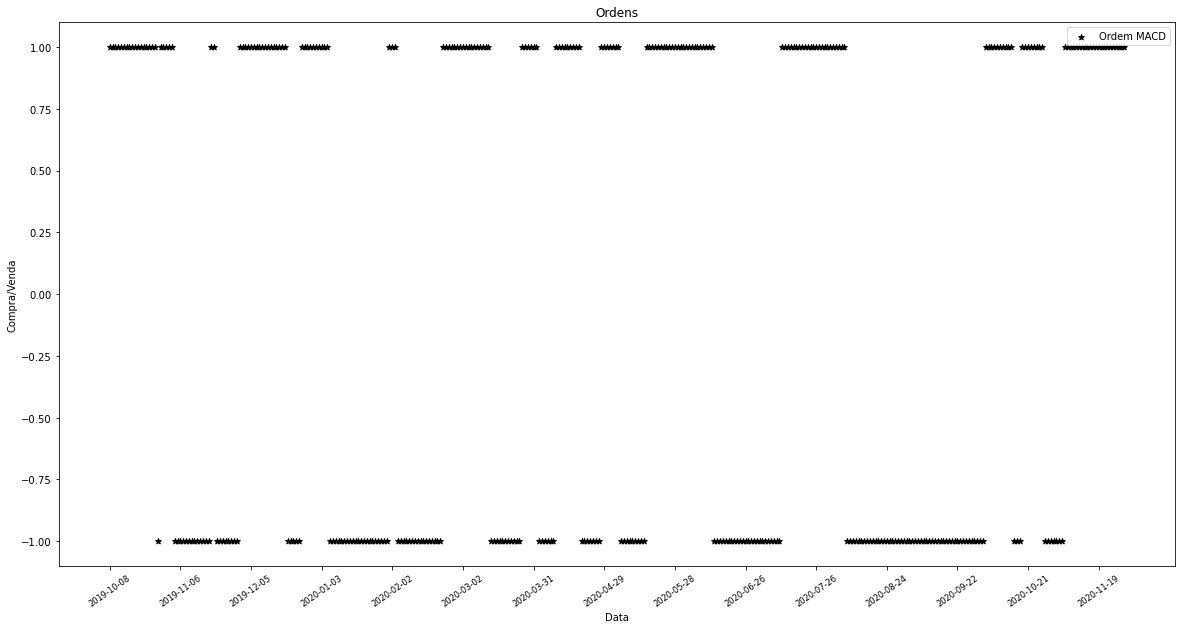

In [303]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(dfMACD.index, dfMACD['invisted macd'], color = 'black', label = 'Ordem MACD', marker = '*', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

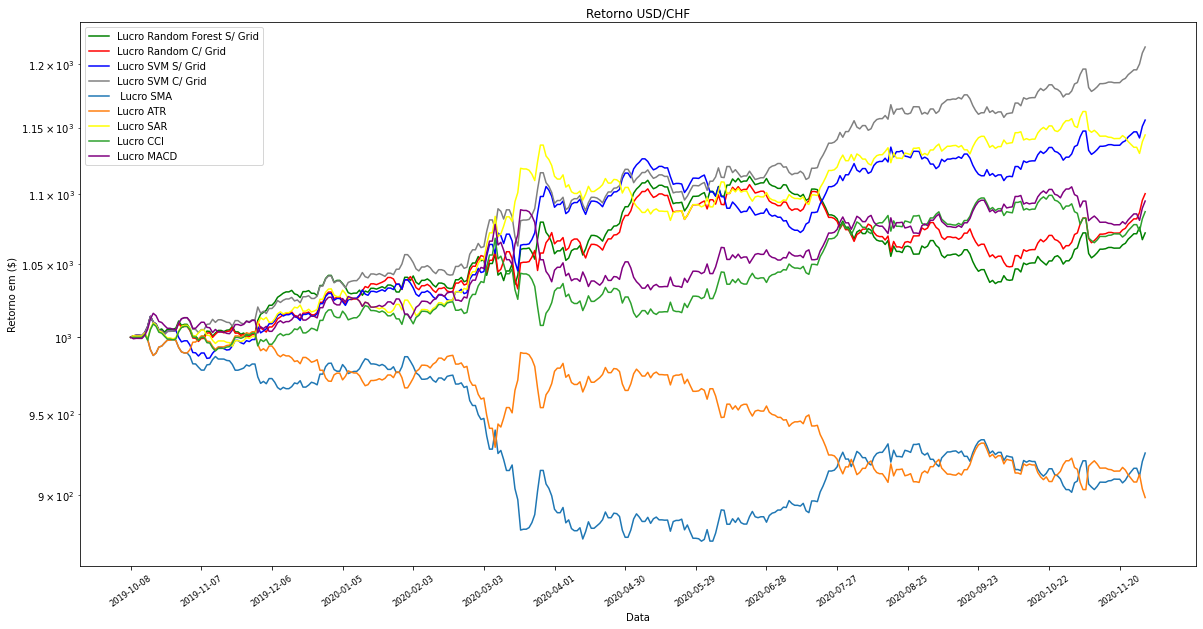

In [140]:
#Visualizando graficamente os retornos de cada estratégia
plt.figure(figsize= (20,10))
plt.plot(lucro.index, lucro['Saldo'], color = 'green', label = 'Lucro Random Forest S/ Grid', alpha=1)
plt.plot(lucroWFA.index, lucroWFA['Saldo'], color = 'red', label = 'Lucro Random C/ Grid', alpha=1)
plt.plot(lucroSvm.index, lucroSvm['Saldo'], color = 'blue', label = 'Lucro SVM S/ Grid', alpha=1)
plt.plot(lucroSvmg.index, lucroSvmg['Saldo'], color = 'gray', label = 'Lucro SVM C/ Grid', alpha=1)
plt.plot(dfSMA.index, dfSMA['Saldo'], label = ' Lucro SMA', alpha =1)
plt.plot(dfATR.index, dfATR['Saldo'], label = 'Lucro ATR', alpha = 1)
plt.plot(dfSAR.index, dfSAR['Saldo'], color='yellow', label = 'Lucro SAR', alpha =1)
plt.plot(dfCCI.index, dfCCI['Saldo'], label = 'Lucro CCI', alpha =1)
plt.plot(dfMACD['Saldo'], label='Lucro MACD',color='purple', alpha =1)
plt.title('Retorno USD/CHF')
plt.yscale("log")
plt.xticks(dfMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Retorno em ($)')
plt.legend( loc = 'upper left')
plt.show()

# Criando DataFrame com os índices

In [176]:
sharpe= [Sharpe_Ratio1,Sharpe_Ratio2,Sharpe_Ratio3,Sharpe_Ratio4,Sharpe_Ratio5, Sharpe_SMA, Sharpe_ATR, Sharpe_SAR, Sharpe_CCI]
calmar=[Calmar_Ratio1,Calmar_Ratio2,Calmar_Ratio3,Calmar_Ratio4,Calmar_Ratio5, Calmar_SMA, Calmar_ATR, Calmar_SAR, Calmar_CCI]
retornoa=[Retorno_anualizado1,Retorno_anualizado2,Retorno_anualizado3,Retorno_anualizado4,Retorno_anualizado5,Retorno_anualizadoSMA, Retorno_anualizadoATR, Retorno_anualizadoSAR,Retorno_anualizadoCCI]
estrategias=['Random Forest sem grid','Random Forest Com Grid','MACD','SVM sem grid','SVM com grid','SMA', 'ATR', 'SAR', 'CCI']
MDD=[MDD1.min(),MDD2.min(),MDD3.min(),MDD4.min(),MDD5.min(), MDDSMA.min(),MDDATR.min(),MDDSAR.min(),MDDCCI.min()]

In [177]:
dfRetorno=pd.DataFrame(estrategias)

In [178]:
dfRetorno.columns=['Estratégia']

In [179]:
dfRetorno.set_index('Estratégia', inplace=True)

In [180]:
dfRetorno.insert(loc=0, column='Sharpe', value=sharpe, allow_duplicates=False)
dfRetorno.insert(loc=1, column='Calmar', value=calmar, allow_duplicates=False)
dfRetorno.insert(loc=2, column='Retorno Anualizado', value=retornoa, allow_duplicates=False)
dfRetorno.insert(loc=3, column='Máximo DrawDown', value=MDD, allow_duplicates=False)

In [181]:
dfRetorno

,Sharpe,Calmar,Retorno Anualizado,Máximo DrawDown
Estratégia,,,,
Random Forest sem grid,0.901168,0.737201,1.035293,-0.069019
Random Forest Com Grid,1.890533,2.173028,1.070967,-0.047907
MACD,1.153924,1.273477,1.045541,-0.051959
SVM sem grid,1.890533,2.173028,1.070967,-0.047907
SVM com grid,2.578357,5.579900,1.093438,-0.024831
SMA,-0.795205,-0.405108,0.962251,-0.129517
ATR,-1.157388,-0.703746,0.946597,-0.104632
SAR,1.758621,1.988614,1.066332,-0.048957
CCI,1.050354,1.080929,1.042180,-0.056447
